<center><h1>Временные ряды</h1></center>

## Ознакомление с данными

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
csv = pd.read_csv("Brent Spot Price.csv")
dat = csv.copy()

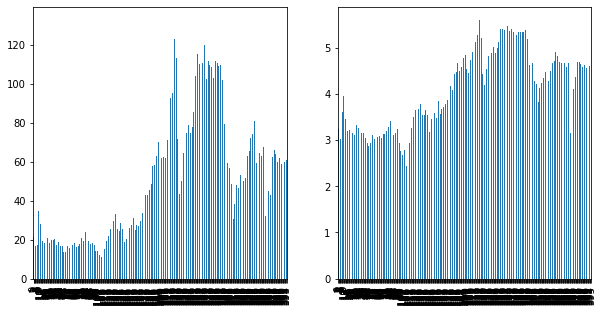

In [3]:
from scipy.stats import boxcox
_, ax = plt.subplots(nrows = 1, ncols = 2)
dat['Brent crude oil spot price, Monthly (dollars per barrel)'].plot(kind='bar', ax=ax[0], figsize=(10, 5))
pd.Series(boxcox(dat['Brent crude oil spot price, Monthly (dollars per barrel)'])[0]).plot(kind='bar', ax=ax[1], figsize=(10, 5))

In [4]:
csv = pd.read_csv("Brent Spot Price.csv")
data = csv.copy()
data

,Unnamed: 0,"Brent crude oil spot price, Monthly (dollars per barrel)"
0,1990 01,21.251
1,1990 02,19.813
2,1990 03,18.387
3,1990 04,16.612
4,1990 05,16.352
...,...,...
391,2022 08,60.000
392,2022 09,60.000
393,2022 10,61.000
394,2022 11,61.000


Названия столбцов неудобные

In [5]:
data.rename(columns={'Unnamed: 0': 'date', 'Brent crude oil spot price, Monthly (dollars per barrel)': 'price'}, inplace=True)

In [6]:
data

,date,price
0,1990 01,21.251
1,1990 02,19.813
2,1990 03,18.387
3,1990 04,16.612
4,1990 05,16.352
...,...,...
391,2022 08,60.000
392,2022 09,60.000
393,2022 10,61.000
394,2022 11,61.000


In [7]:
from datetime import datetime

In [8]:
def str2date(date_series):
    return date_series.apply(lambda date: datetime.strptime(date.strip(), '%Y %m'))

In [9]:
def date2int(date_series):
    date_series = str2date(date_series)
    first_year = date_series[0].year
    return date_series.apply(lambda date: (date.year - first_year) * 12 + date.month)

In [10]:
data['date'] = date2int(data['date'])

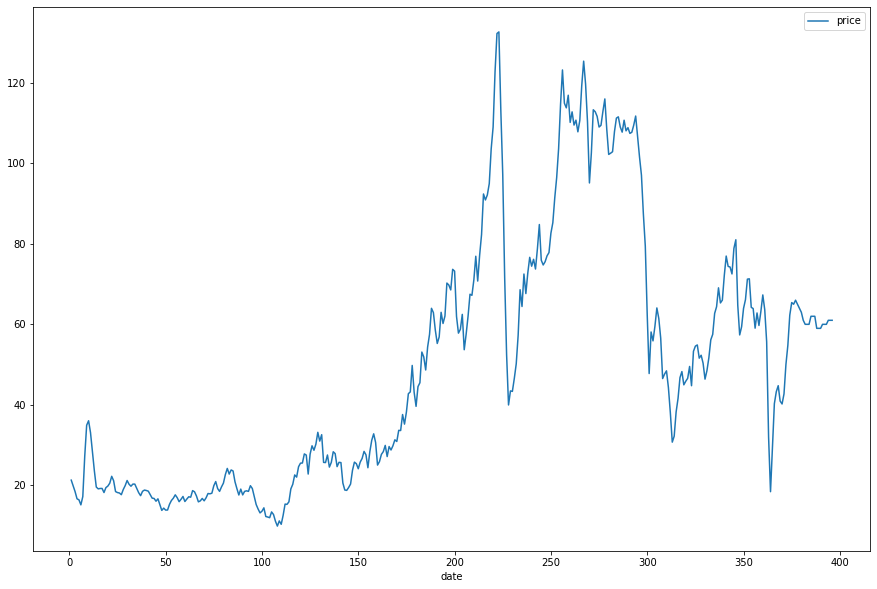

In [11]:
data.plot(kind='line', figsize=(15, 10), x='date', y='price')

Исходя из проведенного анализа данных, заключаем, что ряд моментный, равномерный, с короткой памятью. Также невооруженным глазом изменение дисперсии ряда и слабовыраженный тренд (предположительно, экспоненциальный), что исключает его стационарность. Но проверим.

## Проверим ряд на стационарность

### Дики-Фуллер

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
test = adfuller(data['price'])
print('adf: ', test[0] )
print('p-value: ', test[1])
print('Critical values: ', test[4])

adf:  -2.3662084811231257
p-value:  0.15150178029715117
Critical values:  {'1%': -3.4470566389664703, '5%': -2.8689037160476016, '10%': -2.570692663557422}


Так как adf больше критических интервалов на всех трех доверительных интервалах, ряд не стационарен.

### KPSS

In [14]:
from statsmodels.tsa.stattools import kpss

In [15]:
test = kpss(data['price'])
print('kpss_stat: ', test[0] )
print('p-value: ', test[1])
print('Critical values: ', test[3])

kpss_stat:  1.3399458061693188
p-value:  0.01
Critical values:  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Так как kpss_stat больше все критических значений, ряд не является стационарным.

## ACF и PACF

Проанализируем графики ACF и PACF временного ряда

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

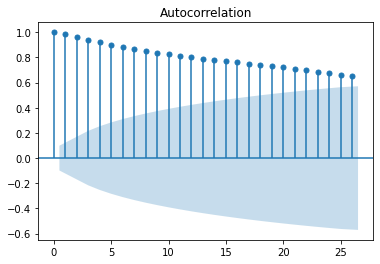

In [17]:
plot_acf(data['price'])
plt.show()

Убывает медленно, следовательно ряд, скорее всего, не стационарен

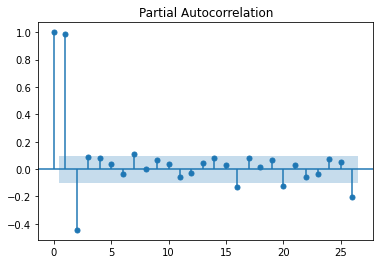

In [18]:
plot_pacf(data['price'])
plt.show()

"Для нестационарного ряда значение в первом лаге близко к единице, однако
остальные значения коэффициентов корреляции статистически незначимы,
т.е. значения не выходят за пределы доверительного интервала. "
Ч.т.д.

Напишем функцию для определения стацинарности ряда

In [19]:
def check_stationarity(series, autocorr=False):
    test1 = adfuller(series)
    test2 = kpss(series)

    if autocorr:
        fig, ax = plt.subplots(nrows = 1, ncols = 2)
        plot_acf(data['price'], ax=ax[0])
        plot_pacf(data['price'], ax=ax[1])
        plt.show()

    if test1[0] < test1[4]['5%'] and test2[0] < test2[3]['5%']:
        return True
    return False

## Найдем основные статистические значения ряда

In [20]:
print("Среднее арифметическое:", data['price'].mean())
print("Медиана:", data['price'].median())
print("Мода:", data['price'].mode()[0])
print("Дисперсия:", data['price'].var())
print("Отклонение:", data['price'].std())
print("Квантиль (25%):", data['price'].quantile(0.25))
print("Квантиль (50%):", data['price'].quantile(0.5))
print("Квантиль (75%):", data['price'].quantile(0.75))

Среднее арифметическое: 49.661244949494936
Медиана: 44.737
Мода: 60.0
Дисперсия: 996.4282575119995
Отклонение: 31.566251876204745
Квантиль (25%): 20.25475
Квантиль (50%): 44.737
Квантиль (75%): 67.2365


## Сглаживание ряда

In [21]:
from scipy.stats import boxcox

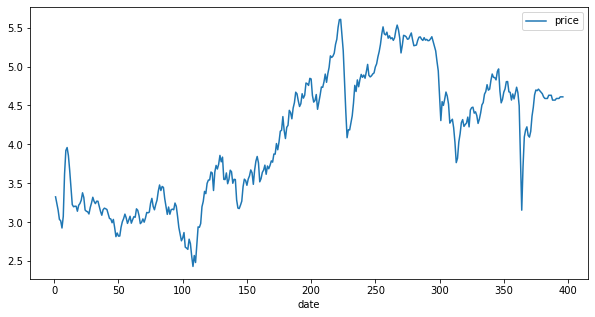

In [22]:
data.plot(kind='line', figsize=(10, 5), x='date', y='price')
data['price'] = pd.Series(boxcox(data['price'])[0])
data.plot(kind='line', figsize=(10, 5), x='date', y='price')

## Приведение к стационарному виду

True


/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


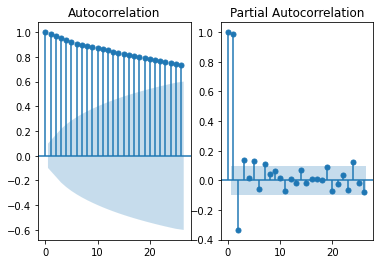

In [23]:
data['price'].diff().plot(kind='line')
print(check_stationarity(data['price'].diff().iloc[1:], autocorr=True))

Так как ряд стал стационарным при первой степени дифференцирования, дальше дифференцирование нам не нужно

## Выявление трендов и прочего-прочего

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [25]:
dates = str2date(csv['Unnamed: 0'])
dates = pd.to_datetime(dates)
data.index = pd.DatetimeIndex(dates)

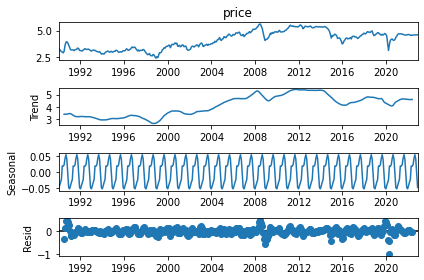

In [26]:
result = seasonal_decompose(data['price'])
result.plot()
plt.show()

Таким образом, в ряду присутствует тренд и сезонность (sic!).

## Разделение выборки

In [27]:
train_size = 0.8
test_start = round(data.shape[0] * train_size)
test_end = data.shape[0]
train = data.iloc[:test_start]
test = data.iloc[test_start-1:]

## Обучение моделей

In [28]:
from sklearn.metrics import mean_squared_error as mse

Как метрику, я решил использовать квадрат минимальных ошибок.

In [29]:
def assess(start_series, true_series, predicted_series):
    plt.figure(figsize=(15, 9))
    plt.plot(true_series)
    plt.plot(predicted_series)
    plt.legend(['test', 'predicted'])
    plt.show()
    
    plt.figure(figsize=(25, 9))
    plt.plot(start_series)
    plt.plot(true_series)
    plt.plot(predicted_series)
    plt.legend(['train', 'test', 'predicted'])
    plt.show()

    print('MSE:', mse(true_series, predicted_series))

### AR

In [30]:
from statsmodels.tsa.ar_model import AutoReg

In [31]:
ar = AutoReg(train['price'], lags=60).fit()

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


MSE: 0.1155607060757741


/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


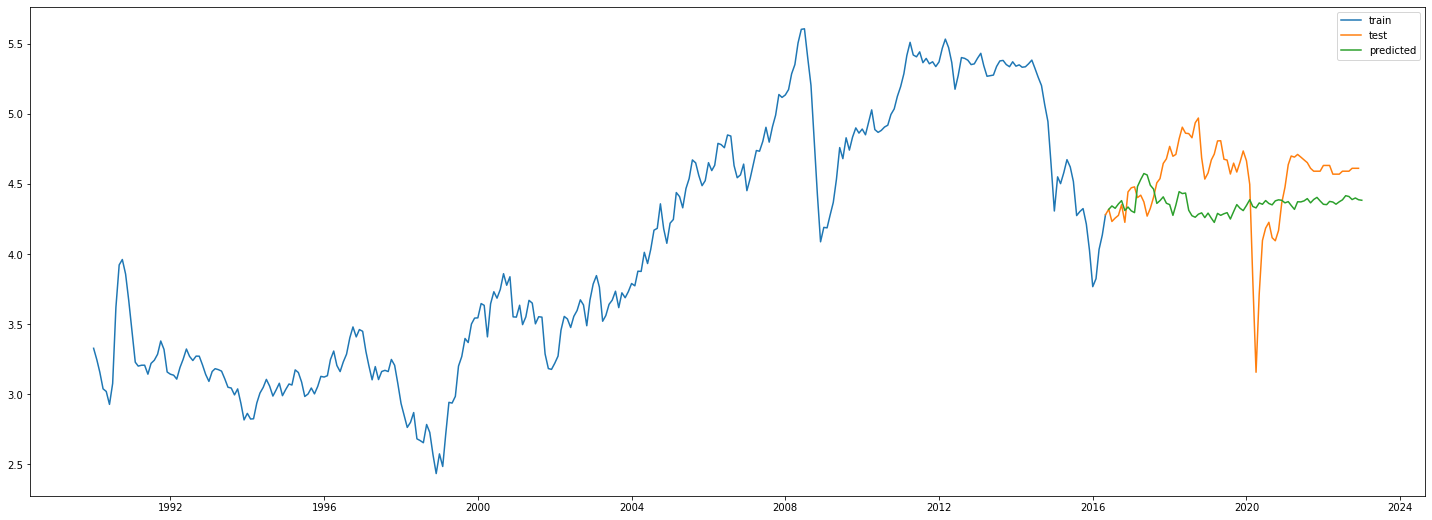

In [32]:
ar_predicted = ar.predict(start=test_start, end=test_end)
assess(train['price'], test['price'], ar_predicted)

### MA

In [33]:
from statsmodels.tsa.arima.model import ARIMA

In [34]:
ma = ARIMA(train['price'], order=(0, 0, 50)).fit()

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/python/envs/default/lib/python3.8/site-packages/statsmodel

MSE: 0.3649290142859335


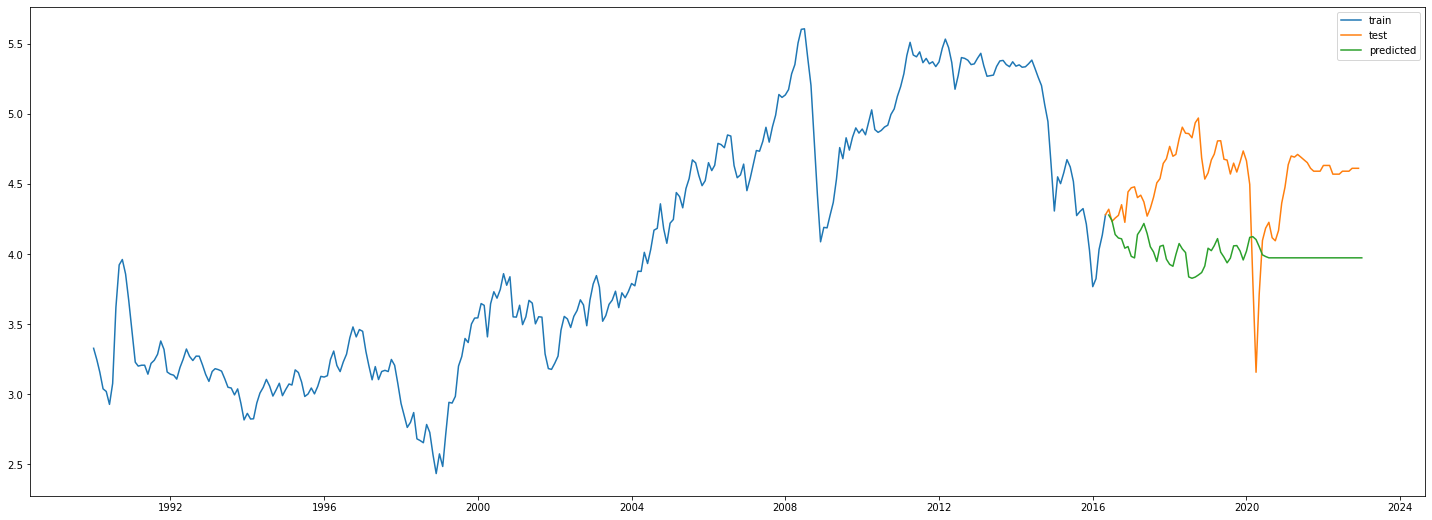

In [35]:
ma_predicted = ma.predict(start=test_start, end=test_end)
assess(train['price'], test['price'], ma_predicted)

### ARMA

In [36]:
arma = ARIMA(train['price'], order=(30, 0, 10), enforce_stationarity=True).fit()

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 0.13433351189709036


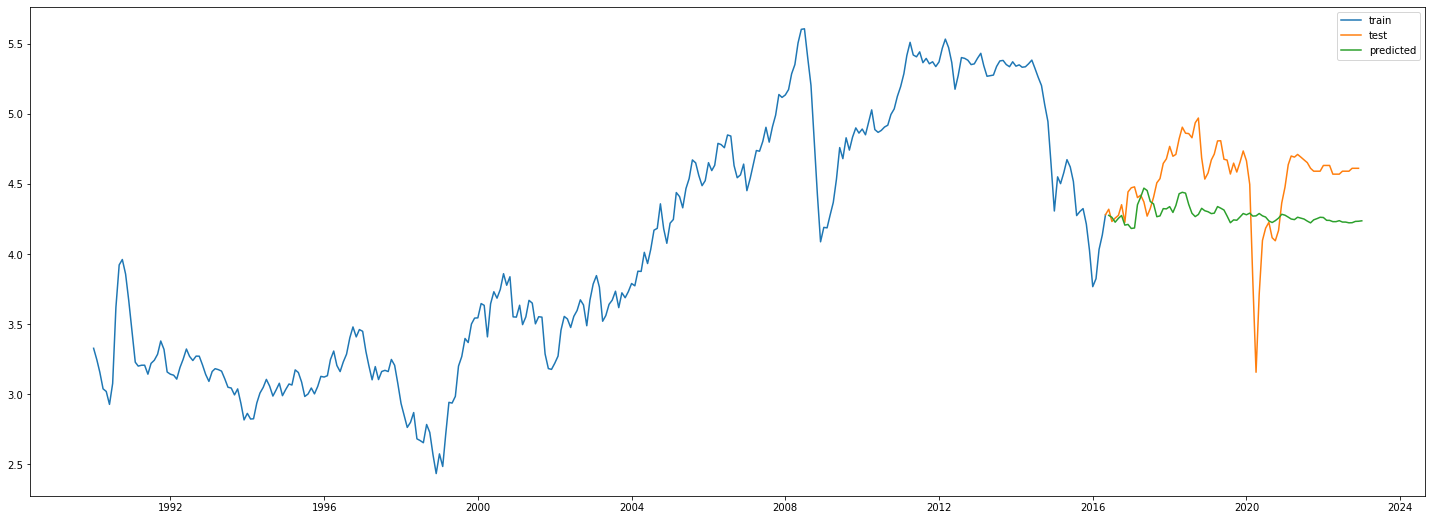

In [37]:
arma_predicted = arma.predict(start=test_start, end=test_end)
assess(train['price'], test['price'], arma_predicted)

### ARIMA

In [38]:
arima = ARIMA(train['price'], order=(30, 1, 10), enforce_stationarity=True).fit()

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 0.11171783224534752


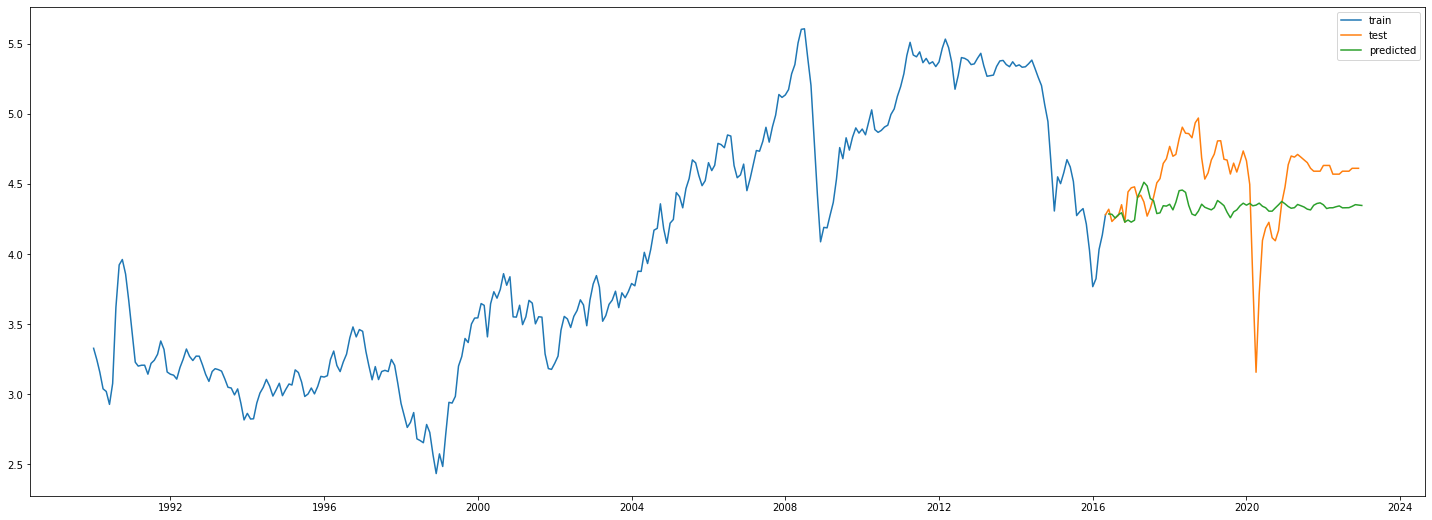

In [39]:
arima_predicted = arima.predict(start=test_start, end=test_end)
assess(train['price'], test['price'], arima_predicted)